In [81]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Loading the data
To get started let's first load in the data! We will make use of the helper functions provided in `data_utils.py`

In [82]:
from data_utils import get_images, get_labels

The following is the list of disasters in our dataset. 

In [83]:
disaster_list = ["hurricane-matthew", "socal-fire", "midwest-flooding"]

We will load each disaster train dataset into a dictionary. Recall that each disaster consists of images and labels (0 - 3) of the damage label.

In [84]:
data = {}
split = "train"
with open('config.json') as config_file:
    config = json.load(config_file)
    data_dir = config['data_dir']

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

Loading train images and labels for hurricane-matthew dataset...
Loading train images and labels for socal-fire dataset...
Loading train images and labels for midwest-flooding dataset...


Let's visualize an image and its label in the dataset. 

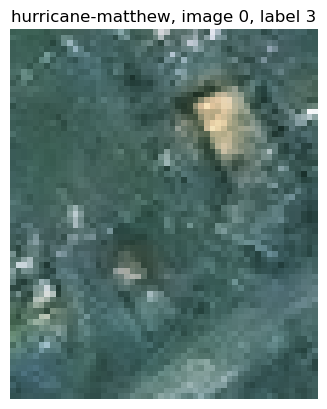

image shape: (65, 54, 3)


In [85]:
disaster = disaster_list[0]
images = data[disaster]["images"]
labels = data[disaster]["labels"]

# index of the image to display
idx = 0
img = images[idx]
label = labels[idx]

plt.title(f"{disaster}, image {idx}, label {label}")
plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.show()

#
print(f"image shape: {img.shape}")

# EDA - Basic Statistics

## Number of Images per Disaster Type


In [93]:
for disaster in disaster_list:
    images = data[disaster]["images"]
    print(f"The {disaster} dataset has {len(images)} images.")

The hurricane-matthew dataset has 11151 images.
The socal-fire dataset has 8380 images.
The midwest-flooding dataset has 7004 images.


## Distribution of Image Sizes in Each Dataset

In [94]:
# Create dataframe with image height, width, and number of pixels
# Damage Labels are in dataframe
data_list = []

for disaster_name, disaster_data in data.items():
    # If a specific disaster is provided, filter for it
    images = disaster_data["images"]  
    damage_labels = disaster_data["labels"]

    for img, damage_label in zip(images, damage_labels):  
        # Extract features
        features = {
            "height": img.shape[0],
            "width": img.shape[1],
            "size": img.shape[0] * img.shape[1],
            "damage_label": damage_label,
            "disaster": disaster_name
        }

        data_list.append(features)  # Append features to list

df_size = pd.DataFrame(data_list)

In [95]:
df_size.isna().sum()

height          0
width           0
size            0
damage_label    0
disaster        0
dtype: int64

In [96]:
df_size.head()

,height,width,size,damage_label,disaster
0,65,54,3510,3,hurricane-matthew
1,67,105,7035,0,hurricane-matthew
2,54,56,3024,1,hurricane-matthew
3,114,124,14136,0,hurricane-matthew
4,58,51,2958,2,hurricane-matthew


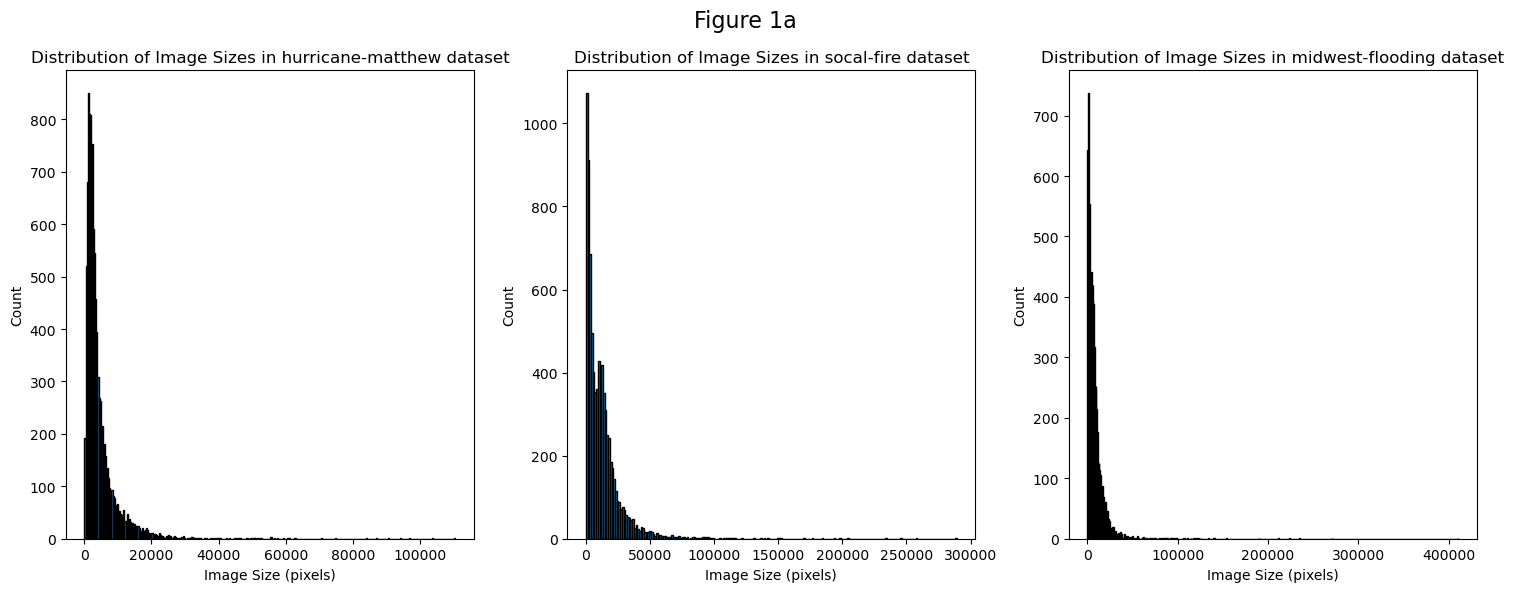

In [97]:
# Create a subplot for graphing
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Plot image size distributions for each disaster type
for i, disaster in enumerate(disaster_list):
    # Filter the DataFrame for the given disaster
    disaster_data = df_size[df_size['disaster'] == disaster]
    
    # Extract the image sizes
    size_array = disaster_data['size']
    
    # Plot histogram in the corresponding subplot
    axes[i].hist(size_array, bins='auto', edgecolor='black')
    axes[i].set_title(f"Distribution of Image Sizes in {disaster} dataset")
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel("Image Size (pixels)")

plt.suptitle("Figure 1a", fontsize=16)
plt.tight_layout()
plt.show()

## Distribution of Damage Labels

In [98]:
# Suppress Warnings
import warnings
warnings.simplefilter("ignore", FutureWarning)

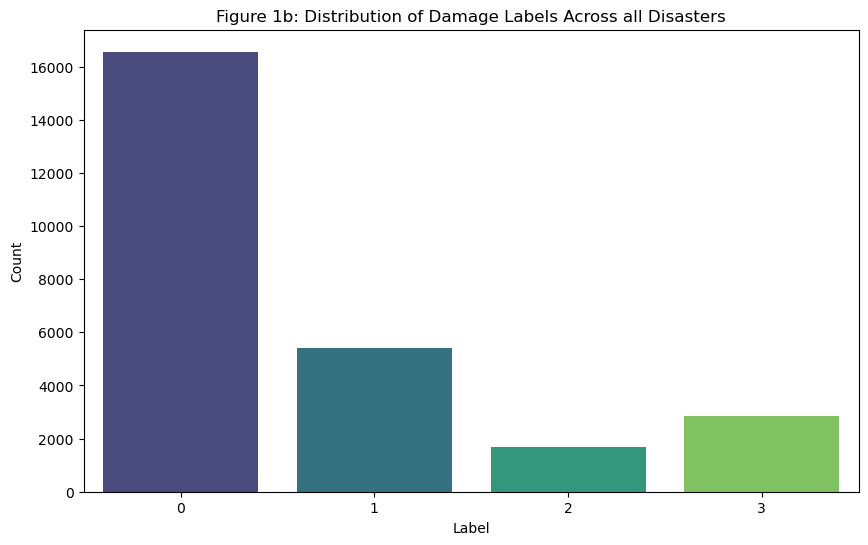

In [99]:
# Plot the histogram of labels in the dataset of all images
plt.figure(figsize=(10, 6))
sns.countplot(x='damage_label', data=df_size, palette="viridis")
plt.title("Figure 1b: Distribution of Damage Labels Across all Disasters")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

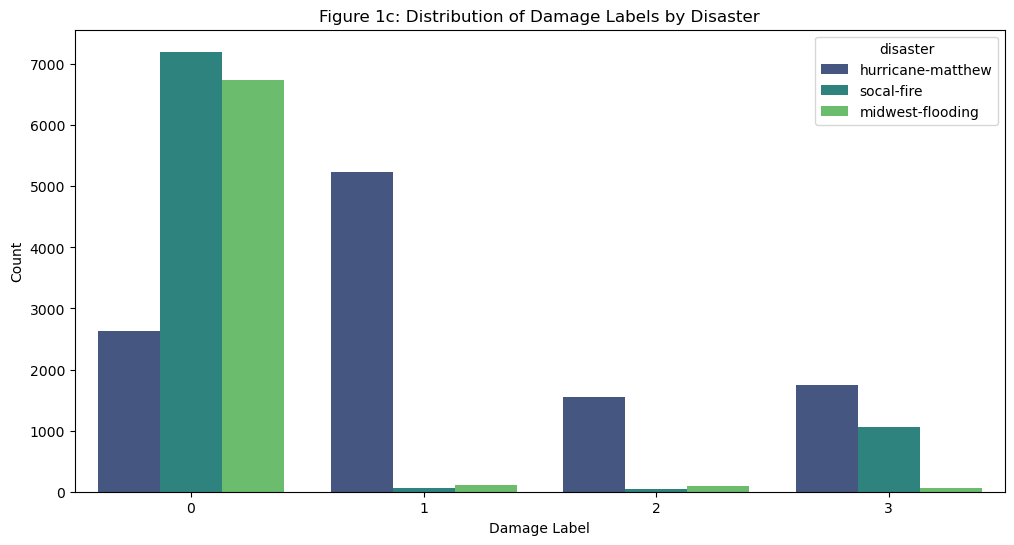

In [100]:
# Plot the histogram of labels by disaster type
plt.figure(figsize=(12, 6))
sns.countplot(x="damage_label", hue="disaster", data=df_size, palette="viridis")
plt.title("Figure 1c: Distribution of Damage Labels by Disaster")
plt.xlabel("Damage Label")
plt.ylabel("Count")
plt.show()

# EDA - Useful Image Features for Classification

### Distribution of Color (RGB)

In [101]:
def create_rgb_df(image_set, labels_set):
    """
    Creates a DataFrame with mean and standard deviation of RGB channels for each image in a set

    Parameters
    -----------
    image_set : list
                A list of images, where each image is represented as a NumPy array of shape (height, width, 3)

    Returns
    --------
    df : pd.DataFrame
        A DataFrame with columns containing the mean and standard deviation of the red, green, and blue channels, respectively
    """
    final_folder = []
    
    for idx, image in enumerate(image_set):
        # Extract label
        label = labels_set[idx]

        # Convert image to uint8 type for image processing
        image = image.astype(np.uint8)

        # Extract individual color channels
        red = np.array(image[:, :, 0])
        greens = np.array(image[:, :, 1])
        blues = np.array(image[:, :, 2])

        # Compute mean values for each of the color channels
        mean_r = np.mean(red)
        mean_g = np.mean(greens)
        mean_b = np.mean(blues)

        # Compute standard deviation for each of the color channels
        std_r = np.std(red)
        std_g = np.std(greens)
        std_b = np.std(blues)
        
        final_folder.append([label, mean_r, mean_g, mean_b, std_r, std_g, std_b])
    
    # Create dataframe with values
    df = pd.DataFrame(final_folder, columns=['damage_label', 'mean_r', 'mean_g', 'mean_b', 'std_r', 'std_g', 'std_b'])

    return df

In [102]:
fire_images = data["socal-fire"]["images"]
fire_labels = data["socal-fire"]["labels"]
rgb_fire_df = create_rgb_df(fire_images, fire_labels)
rgb_fire_df["Disaster"] = 0
rgb_fire_df = rgb_fire_df.drop(columns="damage_label")
rgb_fire_df.head()

,mean_r,mean_g,mean_b,std_r,std_g,std_b,Disaster
0,110.409046,131.513390,126.103811,51.128969,46.496437,51.925517,0
1,70.399918,89.844771,87.334559,22.793470,25.860936,34.624167,0
2,97.319162,122.642376,111.622184,42.198429,37.583086,42.969526,0
3,96.571841,113.395041,108.018512,32.584155,32.684069,37.025957,0
4,76.582532,103.573878,99.056731,26.867641,26.777957,36.632124,0


In [103]:
flooding_images = data["midwest-flooding"]["images"]
flooding_labels = data["midwest-flooding"]["labels"]
rgb_flooding_df = create_rgb_df(flooding_images, flooding_labels)
rgb_flooding_df["Disaster"] = 1
rgb_flooding_df = rgb_flooding_df.drop(columns="damage_label")
rgb_flooding_df.head()

,mean_r,mean_g,mean_b,std_r,std_g,std_b,Disaster
0,99.101461,119.192776,126.047484,26.461066,23.460615,26.590597,1
1,92.032590,111.545818,109.825624,30.047705,26.390695,32.643944,1
2,70.652585,95.393519,86.444637,17.645249,15.644754,22.724778,1
3,122.410779,140.645380,133.836051,48.386851,38.973870,43.524900,1
4,49.225397,82.200397,58.194444,26.080857,23.449150,23.616721,1


In [104]:
df_rgb_all = pd.concat([rgb_flooding_df, rgb_fire_df])
df_rgb_all.head()

,mean_r,mean_g,mean_b,std_r,std_g,std_b,Disaster
0,99.101461,119.192776,126.047484,26.461066,23.460615,26.590597,1
1,92.032590,111.545818,109.825624,30.047705,26.390695,32.643944,1
2,70.652585,95.393519,86.444637,17.645249,15.644754,22.724778,1
3,122.410779,140.645380,133.836051,48.386851,38.973870,43.524900,1
4,49.225397,82.200397,58.194444,26.080857,23.449150,23.616721,1


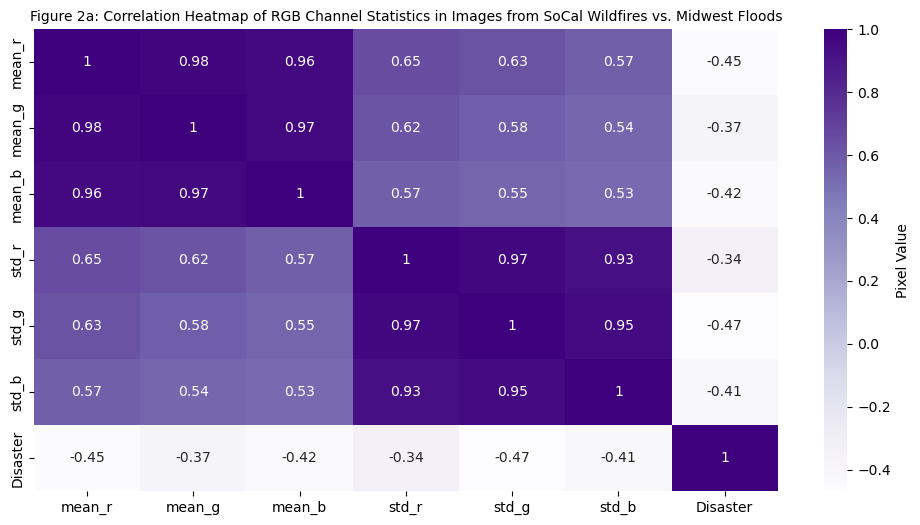

In [105]:
corr = df_rgb_all.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, cmap='Purples', annot=True, cbar_kws={'label': 'Pixel Value'})
plt.title(
    "Figure 2a: Correlation Heatmap of RGB Channel Statistics in Images from SoCal Wildfires vs. Midwest Floods",
    fontsize = 10)
plt.show()

In [106]:
# Feature engineering: add a column called blue/red and a column called (blue + green)/r
df_rgb_all["blue:red ratio"] = df_rgb_all["mean_b"] / df_rgb_all["mean_r"]
df_rgb_all["(green+blue):red ratio"] = (df_rgb_all["mean_b"] + df_rgb_all["mean_g"]) / df_rgb_all["mean_r"]
df_rgb_all.head()

,mean_r,mean_g,mean_b,std_r,std_g,std_b,Disaster,blue:red ratio,(green+blue):red ratio
0,99.101461,119.192776,126.047484,26.461066,23.460615,26.590597,1,1.271903,2.474638
1,92.032590,111.545818,109.825624,30.047705,26.390695,32.643944,1,1.193334,2.405359
2,70.652585,95.393519,86.444637,17.645249,15.644754,22.724778,1,1.223517,2.573694
3,122.410779,140.645380,133.836051,48.386851,38.973870,43.524900,1,1.093336,2.242298
4,49.225397,82.200397,58.194444,26.080857,23.449150,23.616721,1,1.182204,2.852081


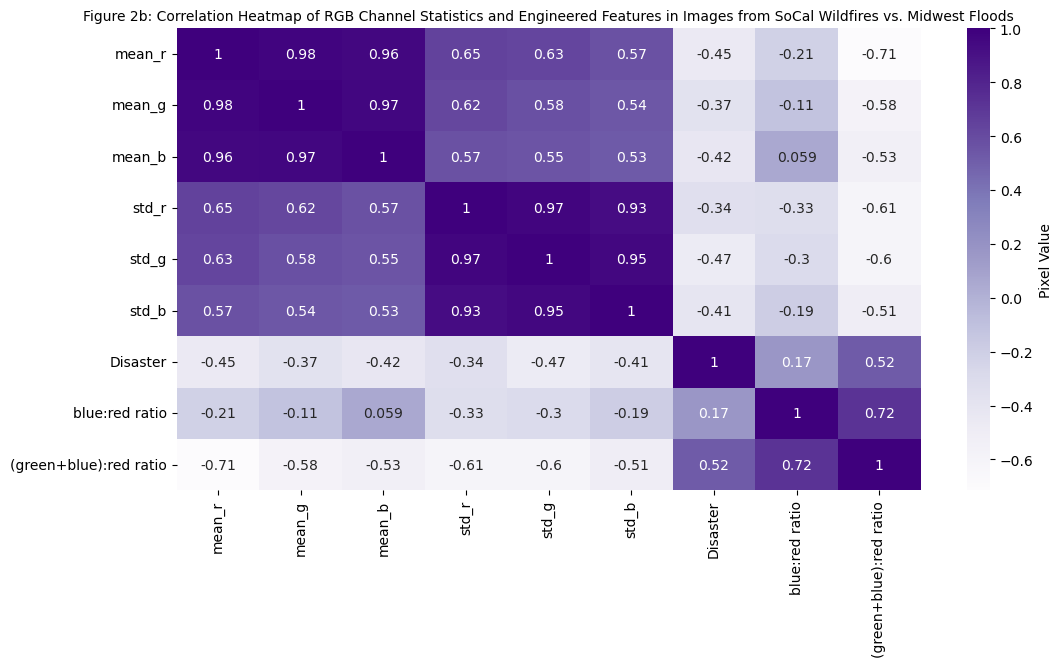

In [107]:
corr = df_rgb_all.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, cmap='Purples', annot=True, cbar_kws={'label': 'Pixel Value'})
plt.title(
    "Figure 2b: Correlation Heatmap of RGB Channel Statistics and Engineered Features in Images from SoCal Wildfires vs. Midwest Floods",
    fontsize = 10)
plt.show()

Based on the above correlation matrix, it appears that the feature engineered column (green + blue)/red is correlated with disaster.

In [108]:
def get_rgb_values(image_set):
    """
    Computes cumulative histograms and outputs the average for the red, green, and blue channels of all images in the provided image set.
    
    Parameters:
    -----------
    image_set : list
                A list of images, where each image is a NumPy array of shape (height, width, 3)

    Returns:
    --------
    mean_r_hist, mean_g_hist, mean_b_hist : numpy arrays
        The averaged histograms for the red, green, and blue channels for all images
    """
    r_hist_cum = []
    g_hist_cum = []
    b_hist_cum = []

    # Extract the individual color channels for each image
    for image in image_set:
        red = image[:, :, 0]
        greens = image[:, :, 1]
        blues = image[:, :, 2]

        # Compute histograms for each color and store in list
        r_histogram = np.histogram(red, bins=256, range=(0, 256))[0]
        r_hist_cum.append(r_histogram)
        g_histogram = np.histogram(greens, bins=256, range=(0, 256))[0]
        g_hist_cum.append(g_histogram)
        b_histogram = np.histogram(blues, bins=256, range=(0, 256))[0]
        b_hist_cum.append(b_histogram)
    
    # Calculate the mean value of each histogram
    mean_r_hist = np.mean(r_hist_cum, axis=0)
    mean_g_hist = np.mean(g_hist_cum, axis=0)
    mean_b_hist = np.mean(b_hist_cum, axis=0)
    return mean_r_hist, mean_g_hist, mean_b_hist

def plt_hist(mean_r_hist, mean_g_hist, mean_b_hist, disaster, figure_num):
    """
    Plots the RGB histograms for the given disaster dataset, based on the provided histograms

    Parameters:
    -----------
    mean_r_hist, mean_g_hist, mean_b_hist : numpy arrays
        The averaged histograms for the red, green, and blue channels
    
    disaster : str
        The name of the disaster dataset (for plot labeling)
    
    figure_num : int
        The figure number for the plot (for plot labeling)
    """
    plt.figure(figsize=(5, 5))

    plt.bar(range(256), mean_r_hist, color='red', alpha=0.5)

    plt.bar(range(256), mean_g_hist, color='green', alpha=0.5)

    plt.bar(range(256), mean_b_hist, color='blue', alpha=0.5)
    plt.title(f"Figure {figure_num}: RGB Histogram from {disaster} Images")
    plt.ylabel("Pixel Intensity")
    plt.xlabel("Pixel Count")


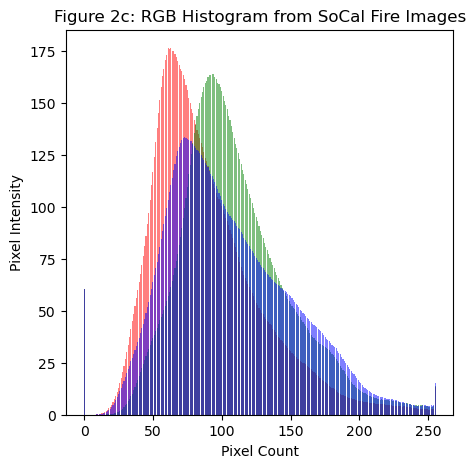

In [109]:
r, g, b = get_rgb_values(fire_images)
plt_hist(r, g, b, "SoCal Fire", "2c")

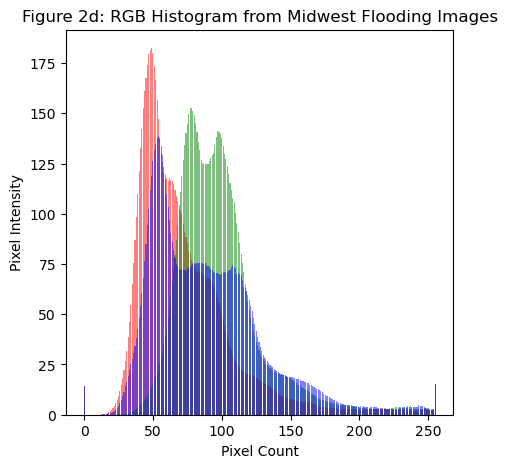

In [110]:
r, g, b = get_rgb_values(flooding_images)
plt_hist(r, g, b, "Midwest Flooding", "2d")

Based on the above histograms it appears that there is a difference in distribution of RGB values for socal fire vs. midwest flooding.

### Image Size

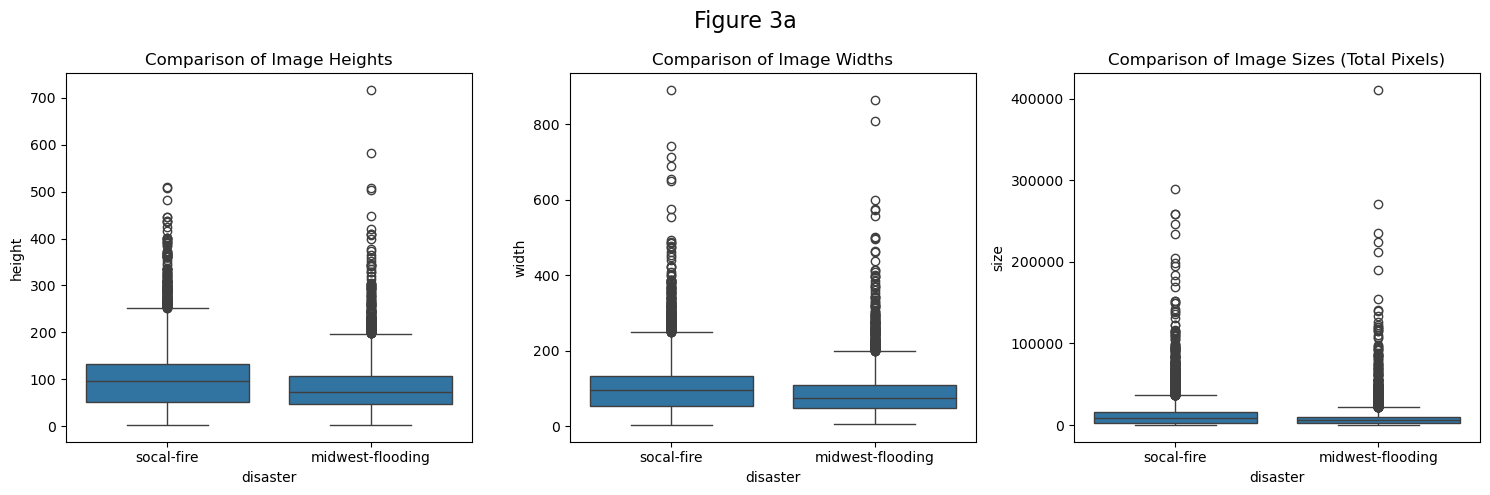

In [111]:
# Filter data for midwest-flooding and socal-fire
df_size_flooding_fire = df_size[df_size["disaster"].isin(["midwest-flooding", "socal-fire"])]

plt.figure(figsize=(15, 5))

# Height comparison
plt.subplot(1, 3, 1)
sns.boxplot(data=df_size_flooding_fire, x="disaster", y="height")
plt.title("Comparison of Image Heights")

# Width comparison
plt.subplot(1, 3, 2)
sns.boxplot(data=df_size_flooding_fire, x="disaster", y="width")
plt.title("Comparison of Image Widths")

# Size comparison
plt.subplot(1, 3, 3)
sns.boxplot(data=df_size_flooding_fire, x="disaster", y="size")
plt.title("Comparison of Image Sizes (Total Pixels)")

plt.suptitle("Figure 3a", fontsize=16)
plt.tight_layout()
plt.show()

In [112]:
# Convert the disaster column to a quantitative column
df_flooding_fire_num = df_size_flooding_fire.copy()
df_flooding_fire_num["disaster_num"] = df_size_flooding_fire["disaster"].map(lambda x: 1 if x == "socal-fire" else 0)
df_flooding_fire_num = df_flooding_fire_num.drop(columns=["disaster", "damage_label"])
df_flooding_fire_num.head()

,height,width,size,disaster_num
11151,144,195,28080,1
11152,48,51,2448,1
11153,104,140,14560,1
11154,128,138,17664,1
11155,65,96,6240,1


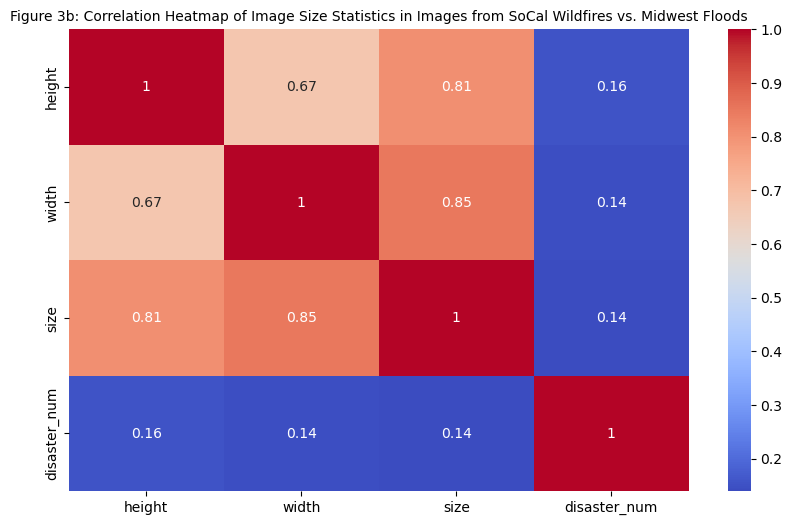

In [113]:
corr = df_flooding_fire_num.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title(
    "Figure 3b: Correlation Heatmap of Image Size Statistics in Images from SoCal Wildfires vs. Midwest Floods",
    fontsize = 10)
plt.show()

In [114]:
# Feature Engineering: Creating additional numerical features for flooding and fire data

# Make a copy of the original dataframe to ensure modifications do not affect the original data
df_flooding_fire_num = df_flooding_fire_num.copy()

# Create polynomial features for height and width
df_flooding_fire_num["h^2"] = df_flooding_fire_num["height"] * df_flooding_fire_num["height"]  # Squared height
df_flooding_fire_num["w^2"] = df_flooding_fire_num["width"] * df_flooding_fire_num["width"]  # Squared width
df_flooding_fire_num["h^3"] = df_flooding_fire_num["height"] * df_flooding_fire_num["height"] * df_flooding_fire_num["height"]  # Cubed height
df_flooding_fire_num["w^3"] = df_flooding_fire_num["width"] * df_flooding_fire_num["width"] * df_flooding_fire_num["width"]  # Cubed width

# Compute the perimeter of the bounding box (assuming it represents a rectangular region)
df_flooding_fire_num["perimeter"] = 2 * (df_flooding_fire_num["height"] + df_flooding_fire_num["width"])  # Perimeter formula for a rectangle

# Create polynomial features for total size (assumed to be the total number of pixels or area)
df_flooding_fire_num["tp^2"] = df_flooding_fire_num["size"] * df_flooding_fire_num["size"]  # Squared size
df_flooding_fire_num["tp^3"] = df_flooding_fire_num["size"] * df_flooding_fire_num["size"] * df_flooding_fire_num["size"]  # Cubed size

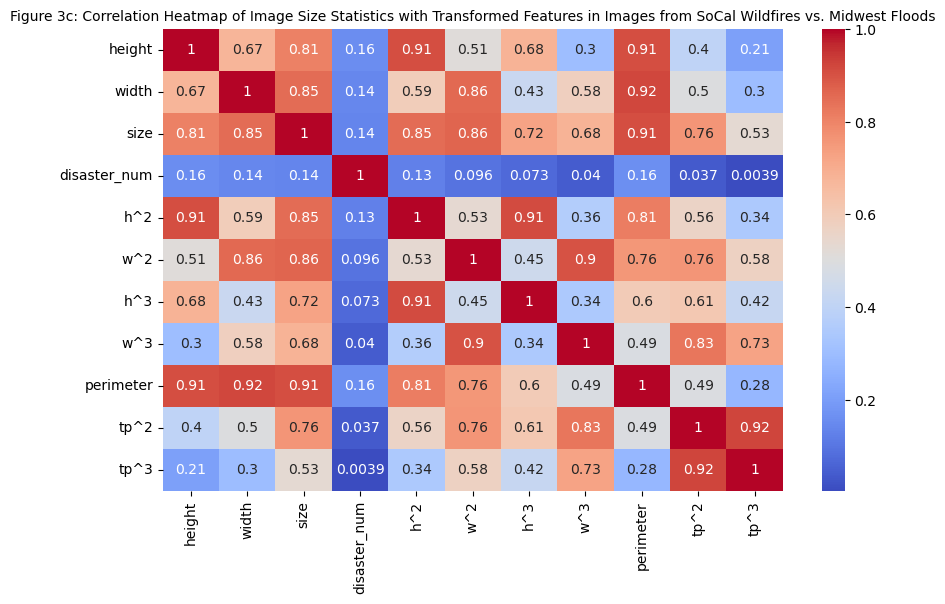

In [115]:
corr = df_flooding_fire_num.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title(
    "Figure 3c: Correlation Heatmap of Image Size Statistics with Transformed Features in Images from SoCal Wildfires vs. Midwest Floods",
    fontsize = 10)
plt.show()

The disaster type does not seem to be correlated with the image size, height or width. We also created other features in the above matrix to test out other possible relationships, but nothing seems correlated with the disaster type.

### Sobel Edges

In [116]:
def create_sobel_df(images, labels):
    """
    Create a DataFrame containing Sobel edge features for a set of images

    Parameters
    -----------
    images : list
            A collection of images (as NumPy arrays).
    
    labels : list
            Corresponding damage labels for each image.

    Returns
    --------
    sobel_data_df : pd.DataFrame 
        A DataFrame with 'damage_label', 'edges', 'mean_edge', and 'edge_density' columns.
    """
    data_list_sobel = []

    for idx, img in enumerate(images):
        label = labels[idx]

        img = img.astype(np.uint8)

        edges = get_sobel_features(img)

        features = {
            "damage_label": label,
            "edges": edges
        }
        
        # Append to list
        data_list_sobel.append(features)

    # Convert list to dataframe
    sobel_data_df = pd.DataFrame(data_list_sobel)

    threshold = 0.05
    sobel_data_df["mean_edge"] = sobel_data_df["edges"].apply(lambda x: np.mean(x))
    sobel_data_df["edge_density"] = sobel_data_df["edges"].apply(lambda x: np.sum(x > threshold) / x.size)

    return sobel_data_df


In [117]:
# Create a DataFrame with Sobel Feature Information
sobel_fire_df = create_sobel_df(fire_images, fire_labels)

# Indicate Fire as 0
sobel_fire_df["disaster"] = 0

# Drop damage label, irrelevant to this analysis
sobel_fire_df.drop(columns="damage_label", inplace=True)
sobel_fire_df.head()

,edges,mean_edge,edge_density,disaster
0,"[[0.008024087707944768, 0.007145051475817372, ...",0.048752,0.318519,0
1,"[[0.052908288707590824, 0.11735449252148385, 0...",0.046197,0.323121,0
2,"[[0.0010979305443423897, 0.01567252947430726, ...",0.043064,0.288187,0
3,"[[0.0022578438098643026, 0.006881435881726285,...",0.044347,0.318161,0
4,"[[0.006977797045282428, 0.020315768077382876, ...",0.037459,0.258654,0


In [118]:
# Create a DataFrame with Sobel Feature Information
sobel_flooding_df = create_sobel_df(flooding_images, flooding_labels)

# Indicate Flooding as 1
sobel_flooding_df["disaster"] = 1

# Drop damage label, irrelevant to this analysis
sobel_flooding_df.drop(columns="damage_label", inplace=True)
sobel_flooding_df.head()

,edges,mean_edge,edge_density,disaster
0,"[[0.007572930416061212, 0.00902097865329088, 0...",0.023776,0.126218,1
1,"[[0.03237482180549751, 0.045244874010661996, 0...",0.022366,0.110754,1
2,"[[0.005705802702260595, 0.00714164649555242, 0...",0.026031,0.141782,1
3,"[[0.011201247009312285, 0.014161875329589147, ...",0.050201,0.264493,1
4,"[[0.031032723018192855, 0.0524221127923293, 0....",0.027389,0.103373,1


In [119]:
# Combine the two dataframes into one
sobel_df = pd.concat([sobel_fire_df, sobel_flooding_df])
sobel_df.head()

,edges,mean_edge,edge_density,disaster
0,"[[0.008024087707944768, 0.007145051475817372, ...",0.048752,0.318519,0
1,"[[0.052908288707590824, 0.11735449252148385, 0...",0.046197,0.323121,0
2,"[[0.0010979305443423897, 0.01567252947430726, ...",0.043064,0.288187,0
3,"[[0.0022578438098643026, 0.006881435881726285,...",0.044347,0.318161,0
4,"[[0.006977797045282428, 0.020315768077382876, ...",0.037459,0.258654,0


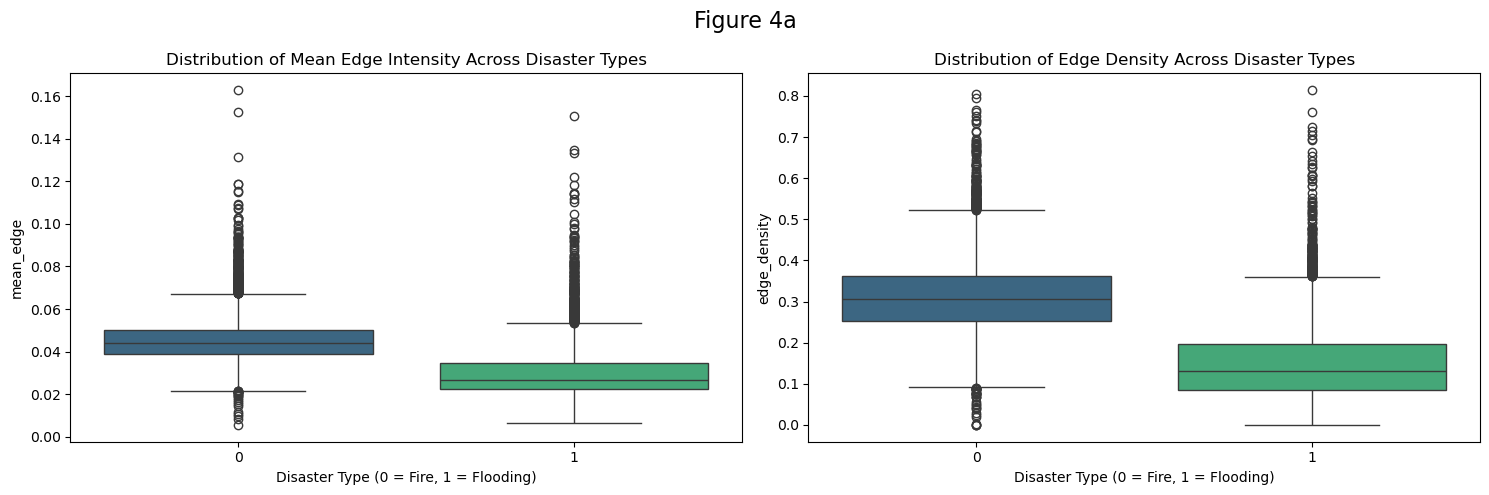

In [120]:
plt.figure(figsize=(15, 5))

# Height comparison
plt.subplot(1, 2, 1)
sns.boxplot(x="disaster", y="mean_edge", data=sobel_df, palette="viridis")
plt.title("Distribution of Mean Edge Intensity Across Disaster Types")
plt.xlabel("Disaster Type (0 = Fire, 1 = Flooding)")

# Width comparison
plt.subplot(1, 2, 2)
sns.boxplot(x="disaster", y="edge_density", data=sobel_df, palette="viridis")
plt.title("Distribution of Edge Density Across Disaster Types")
plt.xlabel("Disaster Type (0 = Fire, 1 = Flooding)")

plt.suptitle("Figure 4a", fontsize=16)
plt.tight_layout()
plt.show()



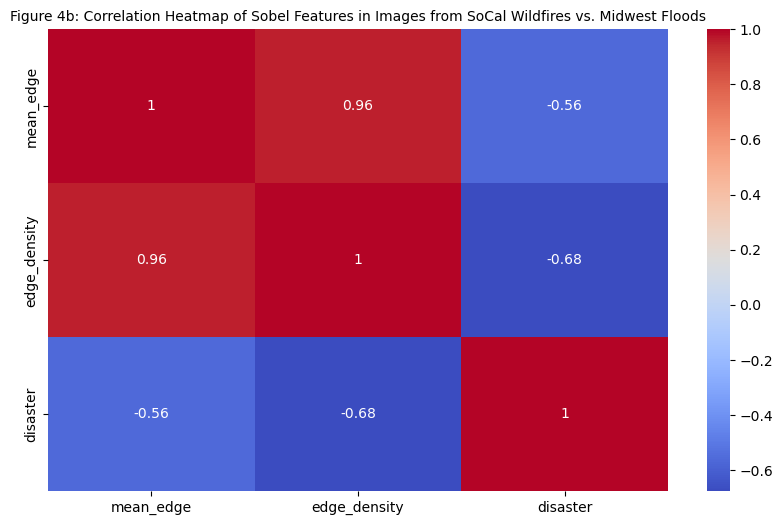

In [121]:
sobel_df = sobel_df.copy()
sobel_df_corr = sobel_df[["mean_edge", "edge_density", "disaster"]]
corr = sobel_df_corr.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title(
    "Figure 4b: Correlation Heatmap of Sobel Features in Images from SoCal Wildfires vs. Midwest Floods",
    fontsize = 10)
plt.show()

Based on the above correlation, it seems like sobel features are important for distinguishing between different disaster types.

### Local Binary Patterns

In [122]:
from scipy.stats import ttest_ind

In [123]:
def create_lbp_df(images, labels):
    """
    Create a DataFrame containing local binary patterns for a set of images

    Parameters
    -----------
    images : list
            A collection of images (as NumPy arrays).
    
    labels : list
            Corresponding damage labels for each image.

    Returns
    --------
    lbp_df : pd.DataFrame 
        A DataFrame with 'damage_label', 'lbp_features', 'lbp_mean', and 'lbp_std' columns.
    """
    data_lbp = []

    for idx, img in enumerate(images):
        # Extract label
        label = labels[idx]

        # Convert image to uint8 type for image processing
        img = img.astype(np.uint8)

        # Extract local binary patterns from the image
        lbp_features = get_local_binary_pattern(img, radius=3)

        features = {
            "damage_label" : label,
            "lbp_features": lbp_features
        }
            
        # Append to list
        data_lbp.append(features)

    # Convert list to dataframe
    lbp_df = pd.DataFrame(data_lbp)

    # Compute mean and standard deviation of LBP arrays for each image
    lbp_df['lbp_mean'] = lbp_df['lbp_features'].apply(np.mean)
    lbp_df['lbp_std'] = lbp_df['lbp_features'].apply(np.std)
    
    return lbp_df

def do_ttests(first_cat_mean, second_cat_mean, first_cat_std, second_cat_std):
    """
    Perform t-tests to compare the means and standard deviations of two categories

    Parameters:
    first_cat_mean : list
                    Mean values of the first category.
    second_cat_mean : list 
                    Mean values of the second category.
    first_cat_std : list 
                    Standard deviation values of the first category
    second_cat_std : list
                    Standard deviation values of the second category
    """
    t_stat_mean, p_val_mean = ttest_ind(first_cat_mean, second_cat_mean, equal_var=False)
    t_stat_std, p_val_std = ttest_ind(first_cat_std, second_cat_std, equal_var=False)

    print("Comparison of LBP Mean:")
    print(f"t-statistic = {t_stat_mean:.3f}, p-value = {p_val_mean:.3e}")
    print("\nComparison of LBP Std:")
    print(f"t-statistic = {t_stat_std:.3f}, p-value = {p_val_std:.3e}") 


In [124]:
fire_lbp_df = create_lbp_df(fire_images, fire_labels)
fire_lbp_df = fire_lbp_df.drop(columns="damage_label")
fire_lbp_df["disaster"] = 0
fire_lbp_df.head()

,lbp_features,lbp_mean,lbp_std,disaster
0,"[[25.0, 25.0, 9.0, 13.0, 7.0, 7.0, 9.0, 25.0, ...",16.013177,8.325785,0
1,"[[6.0, 3.0, 0.0, 0.0, 25.0, 13.0, 25.0, 25.0, ...",15.777369,8.954626,0
2,"[[0.0, 0.0, 25.0, 25.0, 25.0, 5.0, 25.0, 25.0,...",15.734959,8.273992,0
3,"[[5.0, 6.0, 7.0, 8.0, 8.0, 8.0, 25.0, 2.0, 0.0...",15.904608,8.453853,0
4,"[[1.0, 1.0, 25.0, 13.0, 25.0, 0.0, 0.0, 0.0, 1...",16.025641,8.507386,0


In [125]:
flooding_lbp_df = create_lbp_df(flooding_images, flooding_labels)
flooding_lbp_df = flooding_lbp_df.drop(columns="damage_label")
flooding_lbp_df["disaster"] = 1
flooding_lbp_df.head()

,lbp_features,lbp_mean,lbp_std,disaster
0,"[[5.0, 6.0, 2.0, 25.0, 4.0, 25.0, 25.0, 25.0, ...",17.573864,8.781157,1
1,"[[1.0, 25.0, 10.0, 4.0, 1.0, 4.0, 25.0, 25.0, ...",17.751096,8.616508,1
2,"[[7.0, 8.0, 9.0, 25.0, 25.0, 25.0, 0.0, 0.0, 1...",16.970872,8.877299,1
3,"[[7.0, 8.0, 9.0, 7.0, 3.0, 9.0, 25.0, 2.0, 25....",15.889946,8.385532,1
4,"[[0.0, 3.0, 5.0, 6.0, 25.0, 7.0, 25.0, 25.0, 2...",18.269444,8.866672,1


In [126]:
do_ttests(fire_lbp_df['lbp_mean'],flooding_lbp_df['lbp_mean'], fire_lbp_df["lbp_std"], flooding_lbp_df["lbp_std"])

Comparison of LBP Mean:
t-statistic = -99.193, p-value = 0.000e+00

Comparison of LBP Std:
t-statistic = -49.679, p-value = 0.000e+00


In [127]:
# Join the dataframes into one
fireflood_sobel_df = pd.concat([flooding_lbp_df, fire_lbp_df])
fireflood_sobel_df.head()

,lbp_features,lbp_mean,lbp_std,disaster
0,"[[5.0, 6.0, 2.0, 25.0, 4.0, 25.0, 25.0, 25.0, ...",17.573864,8.781157,1
1,"[[1.0, 25.0, 10.0, 4.0, 1.0, 4.0, 25.0, 25.0, ...",17.751096,8.616508,1
2,"[[7.0, 8.0, 9.0, 25.0, 25.0, 25.0, 0.0, 0.0, 1...",16.970872,8.877299,1
3,"[[7.0, 8.0, 9.0, 7.0, 3.0, 9.0, 25.0, 2.0, 25....",15.889946,8.385532,1
4,"[[0.0, 3.0, 5.0, 6.0, 25.0, 7.0, 25.0, 25.0, 2...",18.269444,8.866672,1


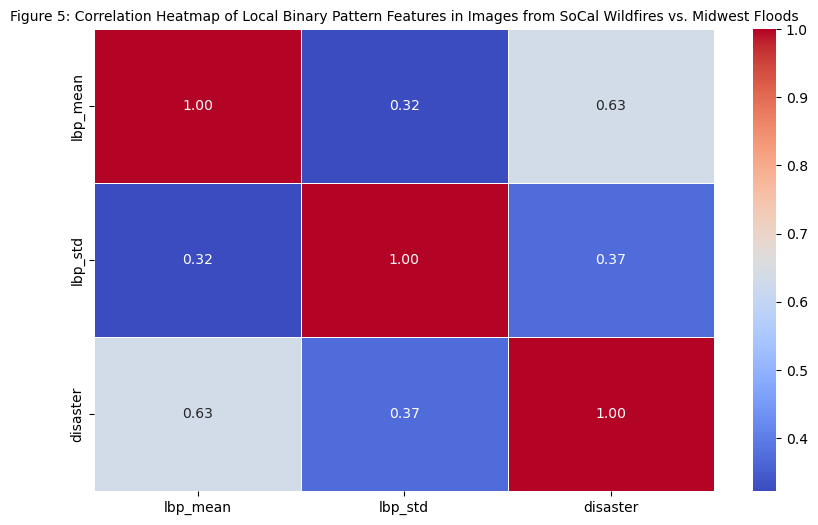

In [128]:
lbp_features = fireflood_sobel_df[['lbp_mean', 'lbp_std', 'disaster']]
lbp_correlation_matrix = lbp_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(lbp_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(
    "Figure 5: Correlation Heatmap of Local Binary Pattern Features in Images from SoCal Wildfires vs. Midwest Floods",
    fontsize = 10)
plt.show()

Based on the above correlation matrix, it seems like local binary pattern mean is correlated with the disaster type.

### Gabor Kernels

In [129]:
def create_gabor_df(images, labels):
    """
    Create a DataFrame containing gabor features for a set of images

    Parameters
    -----------
    images : list
            A collection of images (as NumPy arrays).
    
    labels : list
            Corresponding damage labels for each image.

    Returns
    --------
    gabor_data_df : pd.DataFrame 
        A DataFrame with 'damage_label', 'edges', 'mean_edge', and 'edge_density' columns.
    """
    data_list_gabor = []

    for idx, img in enumerate(images):
        # Extract image labels
        label = labels[idx]

        # Convert image type
        img = img.astype(np.uint8)

        kernel = generate_gabor_kernel(theta, sigma, frequency)
        gabor_features = get_gabor_features(img, kernel)

        features = {
            "damage_label": label,
            "gabor_features": gabor_features
        }
        
        # Append to list
        data_list_gabor.append(features)

    # Convert list to dataframe
    gabor_data_df = pd.DataFrame(data_list_gabor)

    gabor_data_df['gabor_mean'] = gabor_data_df['gabor_features'].apply(np.mean)
    gabor_data_df['gabor_std'] = gabor_data_df['gabor_features'].apply(np.std)

    return gabor_data_df

In [130]:
fire_gabor_df = create_gabor_df(fire_images, fire_labels)
fire_gabor_df = fire_gabor_df.drop(columns="damage_label")
fire_gabor_df["disaster"] = 0
fire_gabor_df.head()

,gabor_features,gabor_mean,gabor_std,disaster
0,"[[0.33956595098668785, 0.2747043053810703, 0.2...",0.407660,0.148212,0
1,"[[0.2706630984365364, 0.27798643643885856, 0.3...",0.275334,0.071469,0
2,"[[0.3479142677386252, 0.3440097595799272, 0.33...",0.374916,0.119482,0
3,"[[0.37471208381113685, 0.3942463911764077, 0.4...",0.352272,0.099551,0
4,"[[0.3102727007387146, 0.2845693050947512, 0.27...",0.313901,0.081102,0


In [131]:
flooding_gabor_df = create_gabor_df(flooding_images, flooding_labels)
flooding_gabor_df = flooding_gabor_df.drop(columns="damage_label")
flooding_gabor_df["disaster"] = 1
flooding_gabor_df.head()

,gabor_features,gabor_mean,gabor_std,disaster
0,"[[0.3514807094911371, 0.3655224133982402, 0.37...",0.371539,0.073826,1
1,"[[0.33934024426134285, 0.32149138532875793, 0....",0.345328,0.085645,1
2,"[[0.2861732529242971, 0.30191191743446555, 0.2...",0.288078,0.047272,1
3,"[[0.4372494352420624, 0.41344719843680133, 0.4...",0.438695,0.121312,1
4,"[[0.28256016591828353, 0.28526477735380606, 0....",0.236481,0.071613,1


In [132]:
do_ttests(fire_gabor_df['gabor_mean'], flooding_gabor_df['gabor_mean'], fire_gabor_df['gabor_std'], flooding_gabor_df['gabor_std'])

Comparison of LBP Mean:
t-statistic = 53.878, p-value = 0.000e+00

Comparison of LBP Std:
t-statistic = 59.835, p-value = 0.000e+00


In [133]:
# Join the dataframes into one
fireflood_gabor_df = pd.concat([flooding_gabor_df, fire_gabor_df])
fireflood_gabor_df = fireflood_gabor_df.drop(columns="gabor_features")
fireflood_gabor_df.head()

,gabor_mean,gabor_std,disaster
0,0.371539,0.073826,1
1,0.345328,0.085645,1
2,0.288078,0.047272,1
3,0.438695,0.121312,1
4,0.236481,0.071613,1


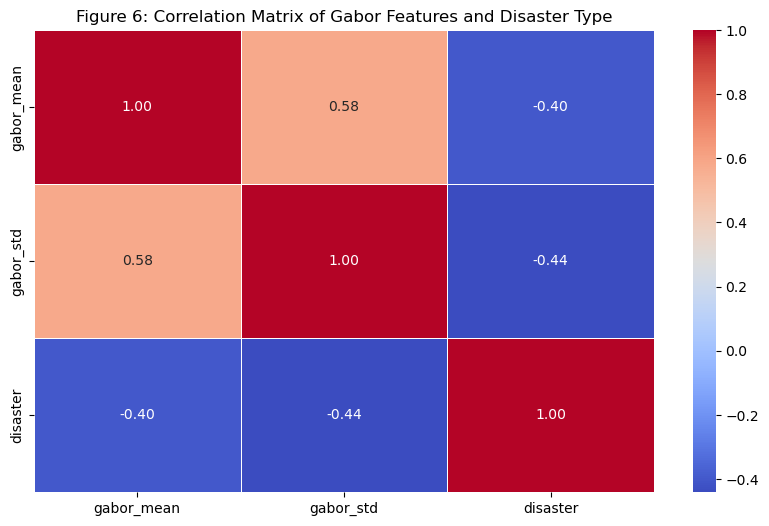

In [134]:
gabor_correlation_matrix = fireflood_gabor_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(gabor_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Figure 6: Correlation Matrix of Gabor Features and Disaster Type")
plt.show()

Based on the above correlation matrix, it seems like gabor mean and gabor standard deviation have a correlation to the type of disaster.

# 2. Damage Labels 1 vs 3 within the `hurricane-matthew` dataset

Is there a relationship between the damage label and:

- image height, width, or overall size?
- RGB values?
- Sobel edges?
- Local Binary Patterns?
- Gabor kernels?

In [135]:
# Define all images and labels
hurricane_m = disaster_list[0]
hurricane_images = data[hurricane_m]["images"]
hurricane_labels = data[hurricane_m]["labels"]

### Distribution of Color (RGB)

In [136]:
hurricane_rgb_df = create_rgb_df(hurricane_images, hurricane_labels)

# Filter out damage labels 0 and 2
hurricane_rgb_df = hurricane_rgb_df[~hurricane_rgb_df['damage_label'].isin([0, 2])] 
hurricane_rgb_df.head()

,damage_label,mean_r,mean_g,mean_b,std_r,std_g,std_b
0,3,75.702279,105.275783,101.084046,27.815519,23.648597,23.464383
2,1,111.971561,122.160714,119.043320,50.665334,44.679265,42.979921
5,1,79.809627,101.363440,87.303948,38.145894,30.901838,31.373991
7,1,97.136364,120.681818,127.575758,22.035476,21.082804,26.389982
8,1,125.915455,134.622273,134.193636,42.648427,39.414701,42.140185


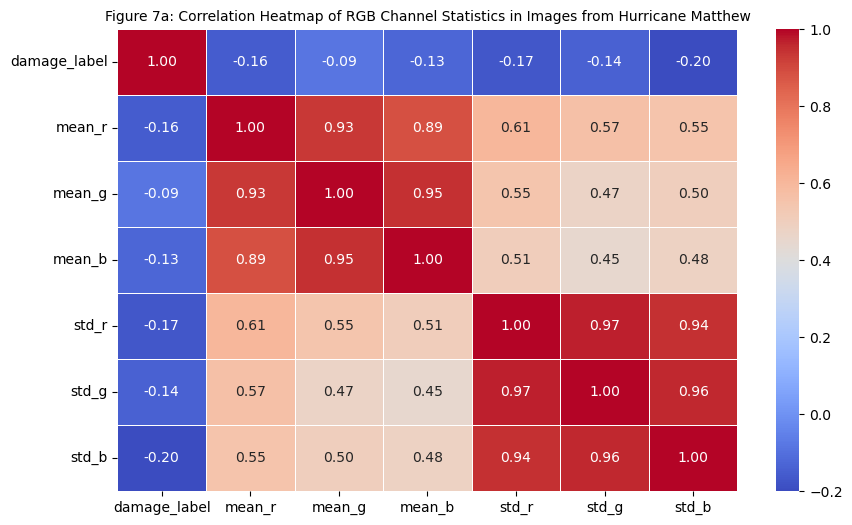

In [137]:
rgb_correlation_matrix = hurricane_rgb_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(rgb_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(
    "Figure 7a: Correlation Heatmap of RGB Channel Statistics in Images from Hurricane Matthew",
    fontsize = 10)
plt.show()

It seems like RGB values are not correlated with damage label. Try to transform these features to see if there's any way to increase the correlation.

In [138]:
# Feature engineering: add a column called blue/red and a column called (blue + green)/r
hurricane_rgb_df = hurricane_rgb_df.copy()
hurricane_rgb_df["b+g/r"] = (hurricane_rgb_df["mean_b"] + hurricane_rgb_df["mean_g"])/ hurricane_rgb_df["mean_r"]
hurricane_rgb_df["stdb^2"] = hurricane_rgb_df["std_b"]*hurricane_rgb_df["std_b"]
hurricane_rgb_df.head()

,damage_label,mean_r,mean_g,mean_b,std_r,std_g,std_b,b+g/r,stdb^2
0,3,75.702279,105.275783,101.084046,27.815519,23.648597,23.464383,2.725939,550.577267
2,1,111.971561,122.160714,119.043320,50.665334,44.679265,42.979921,2.154154,1847.273586
5,1,79.809627,101.363440,87.303948,38.145894,30.901838,31.373991,2.363968,984.327302
7,1,97.136364,120.681818,127.575758,22.035476,21.082804,26.389982,2.555764,696.431129
8,1,125.915455,134.622273,134.193636,42.648427,39.414701,42.140185,2.134892,1775.795232


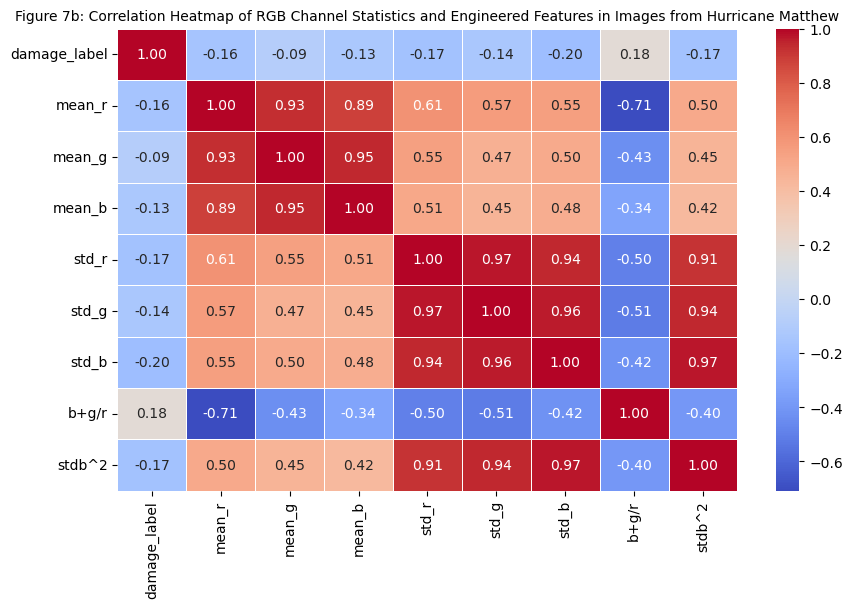

In [139]:
corr = hurricane_rgb_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(
    "Figure 7b: Correlation Heatmap of RGB Channel Statistics and Engineered Features in Images from Hurricane Matthew",
    fontsize = 10)
plt.show()

Based on the RGB correlation matrix above, there seems to be little correlation between RGB and damage label.

### Image Size

In [140]:
disaster_size_label_df = df_size[~df_size['damage_label'].isin([0, 2])] 
disaster_size_label_df = disaster_size_label_df[disaster_size_label_df['disaster'] == "hurricane-matthew"] 
disaster_size_label_df.drop(columns="disaster", inplace=True)
disaster_size_label_df.head()

,height,width,size,damage_label
0,65,54,3510,3
2,54,56,3024,1
5,43,43,1849,1
7,12,33,396,1
8,50,44,2200,1


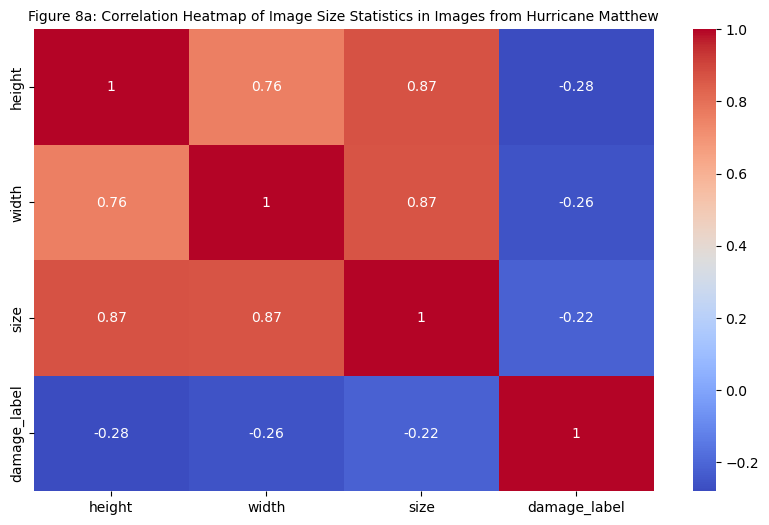

In [141]:
corr = disaster_size_label_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title(
    "Figure 8a: Correlation Heatmap of Image Size Statistics in Images from Hurricane Matthew",
    fontsize = 10)
plt.show()

In [142]:
# Feature Engineering: Creating additional features based on image size

# Make a copy of the original dataframe to avoid modifying it directly
disaster_size_df = disaster_size_label_df.copy()

# Create polynomial features for height and width
disaster_size_df["h^2"] = disaster_size_df["height"] * disaster_size_df["height"]  # Squared height
disaster_size_df["w^2"] = disaster_size_df["width"] * disaster_size_df["width"]  # Squared width
disaster_size_df["h^3"] = disaster_size_df["height"] * disaster_size_df["height"] * disaster_size_df["height"]  # Cubed height
disaster_size_df["w^3"] = disaster_size_df["width"] * disaster_size_df["width"] * disaster_size_df["width"]  # Cubed width

# Compute the perimeter of the image
disaster_size_df["perimeter"] = 2 * (disaster_size_df["height"] + disaster_size_df["width"])  # Perimeter of a rectangle

# Create polynomial features for total pixel count
disaster_size_df["tp^2"] = disaster_size_df["size"] * disaster_size_df["size"]  # Squared total pixels
disaster_size_df["tp^3"] = disaster_size_df["size"] * disaster_size_df["size"] * disaster_size_df["size"]  # Cubed total pixels

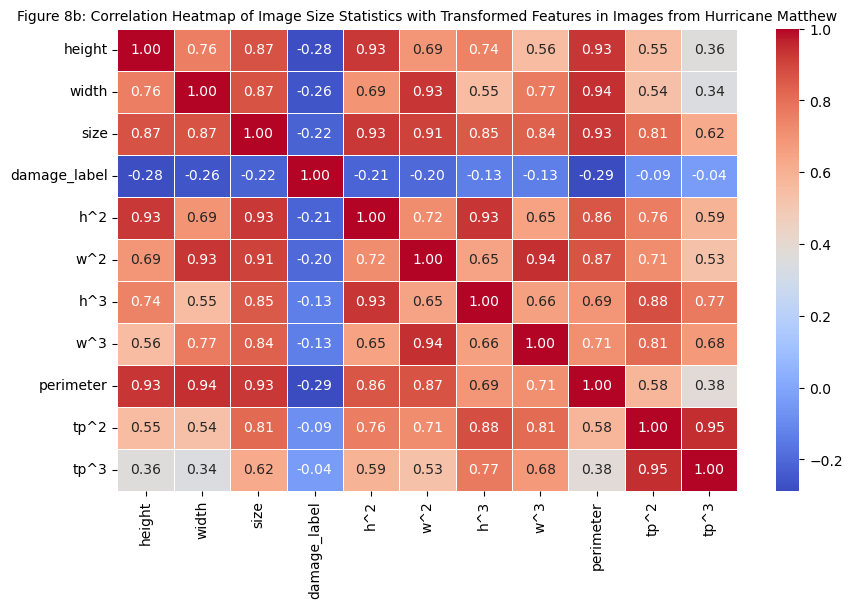

In [143]:
corr = disaster_size_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(
    "Figure 8b: Correlation Heatmap of Image Size Statistics with Transformed Features in Images from Hurricane Matthew",
    fontsize = 10)
plt.show()

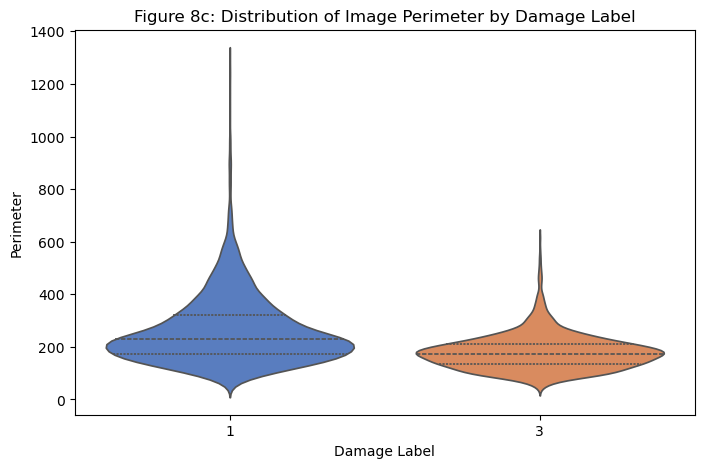

In [144]:
# Create violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(x="damage_label", y="perimeter", data=disaster_size_df, inner="quartile", palette="muted")

# Labels
plt.xlabel("Damage Label")
plt.ylabel("Perimeter")
plt.title("Figure 8c: Distribution of Image Perimeter by Damage Label")

# Show plot
plt.show()

Based on the above analysis, it seems like height, width, total pixels, height^2 and perimeter all have correlations above >0.2 to damage label. The perimeter is most strongly correlated with damage labels out of all of the features we engineered.

### Sobel Edges

In [145]:
# Create a DataFrame with Sobel Feature Information
sobel_hurricane_df = create_sobel_df(hurricane_images, hurricane_labels)

# Filter DataFrame so it only contains damage Labels 1 and 3
sobel_hurricane_df = sobel_hurricane_df[~sobel_hurricane_df['damage_label'].isin([0, 2])]
sobel_hurricane_df.head()

,damage_label,edges,mean_edge,edge_density
0,3,"[[0.034433043788580836, 0.016052798967186116, ...",0.057136,0.399715
2,1,"[[0.030610908256325887, 0.04348948728327182, 0...",0.066945,0.499669
5,1,"[[0.03569423594126911, 0.03551794933064095, 0....",0.057615,0.393186
7,1,"[[0.011279223139682756, 0.019974058349259874, ...",0.052025,0.378788
8,1,"[[0.06530157918452424, 0.03376482215270568, 0....",0.083214,0.604545


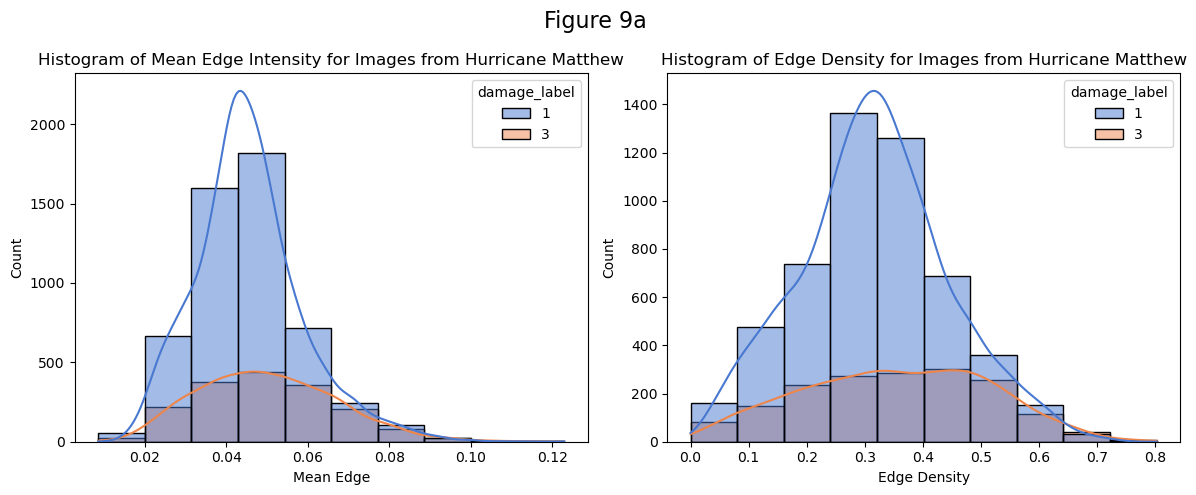

In [146]:
# Create histograms on subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for mean edge
sns.histplot(sobel_hurricane_df, x="mean_edge", hue="damage_label", bins=10, kde=True, ax=axes[0], palette="muted")
axes[0].set_title("Histogram of Mean Edge Intensity for Images from Hurricane Matthew")
axes[0].set_xlabel("Mean Edge")

# Histogram for edge density
sns.histplot(sobel_hurricane_df, x="edge_density", hue="damage_label", bins=10, kde=True, ax=axes[1], palette="muted")
axes[1].set_title("Histogram of Edge Density for Images from Hurricane Matthew")
axes[1].set_xlabel("Edge Density")

# Show plot and label
plt.suptitle("Figure 9a", fontsize=16)
plt.tight_layout()
plt.show()

In [147]:
sobel_data_df_corr = sobel_hurricane_df[["mean_edge", "edge_density", "damage_label"]]
sobel_data_df_corr.head()

,mean_edge,edge_density,damage_label
0,0.057136,0.399715,3
2,0.066945,0.499669,1
5,0.057615,0.393186,1
7,0.052025,0.378788,1
8,0.083214,0.604545,1


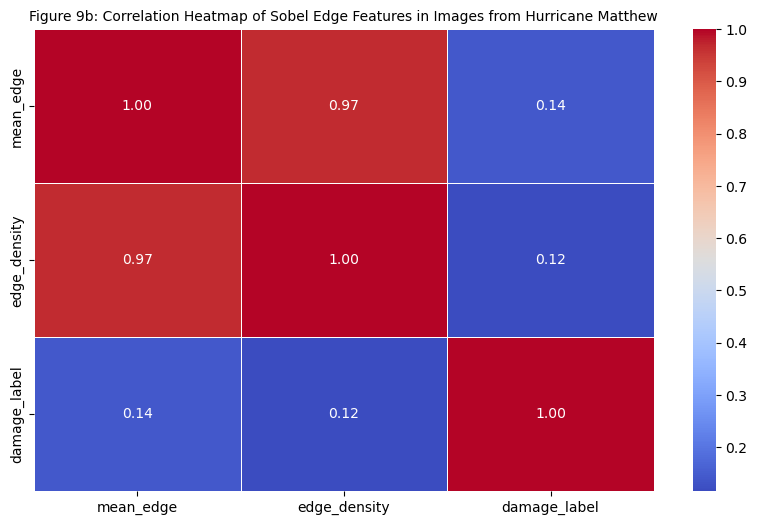

In [148]:
corr = sobel_data_df_corr.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(
    "Figure 9b: Correlation Heatmap of Sobel Edge Features in Images from Hurricane Matthew",
    fontsize = 10)
plt.show()

Based on the above visualizations, there's little correlation between Sobel Edge mean density, edge density and damage label.

### Local Binary Patterns

In [149]:
hurricane_lbp_df = create_lbp_df(hurricane_images, hurricane_labels)
# filter out all damage labels except 1 and 3
hurricane_lbp_df = hurricane_lbp_df[~hurricane_lbp_df['damage_label'].isin([0, 2])] 
hurricane_lbp_df.head()

,damage_label,lbp_features,lbp_mean,lbp_std
0,3,"[[25.0, 25.0, 2.0, 5.0, 25.0, 25.0, 13.0, 25.0...",18.618803,9.261844
2,1,"[[6.0, 8.0, 10.0, 13.0, 25.0, 25.0, 25.0, 2.0,...",18.507275,9.241359
5,1,"[[7.0, 8.0, 25.0, 25.0, 25.0, 0.0, 1.0, 4.0, 8...",17.981612,9.588036
7,1,"[[25.0, 3.0, 0.0, 25.0, 5.0, 13.0, 10.0, 25.0,...",13.949495,9.227893
8,1,"[[0.0, 1.0, 2.0, 25.0, 25.0, 2.0, 3.0, 5.0, 6....",15.632273,9.188766


In [150]:
label1 = hurricane_lbp_df[hurricane_lbp_df['damage_label'] == 1]
label3 = hurricane_lbp_df[hurricane_lbp_df['damage_label'] == 3]

do_ttests(label1['lbp_mean'], label3['lbp_mean'], label1['lbp_std'], label3['lbp_std'])

Comparison of LBP Mean:
t-statistic = -34.113, p-value = 7.223e-210

Comparison of LBP Std:
t-statistic = -33.699, p-value = 3.834e-211


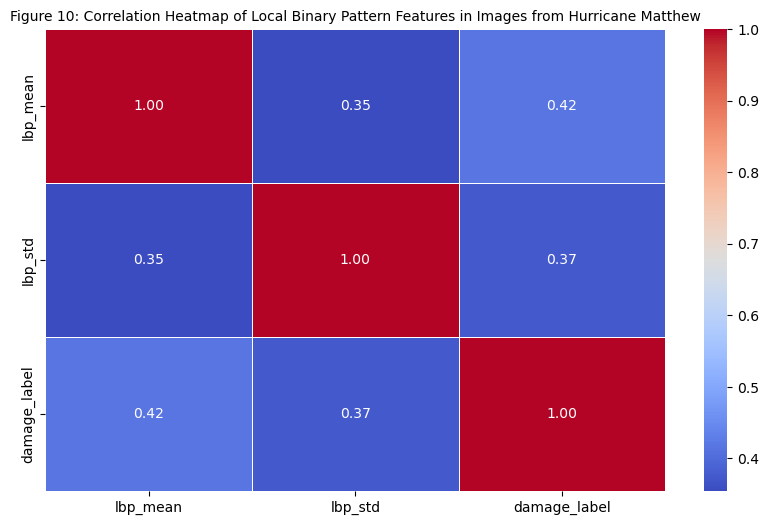

In [151]:
lbp_features = hurricane_lbp_df[['lbp_mean', 'lbp_std', 'damage_label']]
lbp_correlation_matrix = lbp_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(lbp_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(
    "Figure 10: Correlation Heatmap of Local Binary Pattern Features in Images from Hurricane Matthew",
    fontsize = 10)
plt.show()

Based on the above visualizations, the label is correlated with the local binary pattern mean and standard deviation.

### Gabor Kernels

In [152]:
hurricane_gabor_df = create_gabor_df(hurricane_images, hurricane_labels)

# Filter out all damage labels except 1 and 3
hurricane_gabor_df = hurricane_gabor_df[~hurricane_gabor_df['damage_label'].isin([0, 2])] 

In [153]:
# Separate data into two groups based on label
label1 = hurricane_gabor_df[hurricane_gabor_df['damage_label'] == 1]
label3 = hurricane_gabor_df[hurricane_gabor_df['damage_label'] == 3]

do_ttests(label1['gabor_mean'], label3['gabor_mean'], label1['gabor_std'], label3['gabor_std'])

Comparison of LBP Mean:
t-statistic = 8.357, p-value = 1.023e-16

Comparison of LBP Std:
t-statistic = 19.968, p-value = 3.025e-83


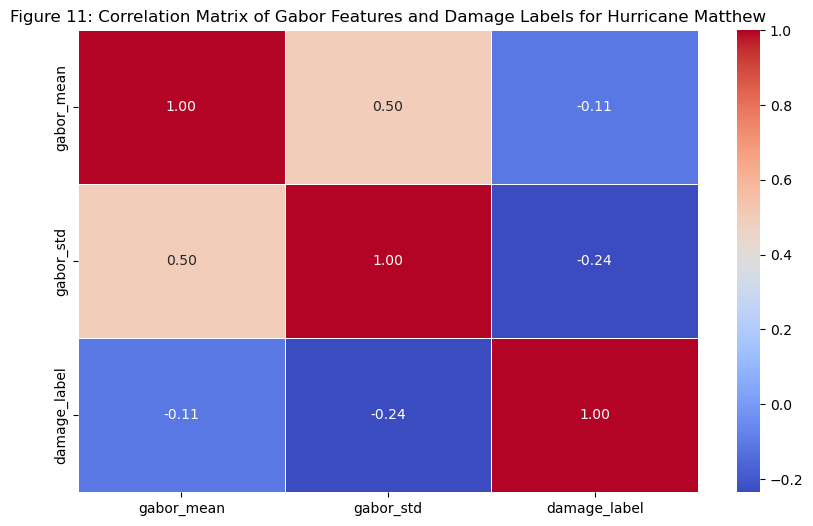

In [154]:
gabor_features = hurricane_gabor_df[['gabor_mean', 'gabor_std', 'damage_label']]
gabor_correlation_matrix = gabor_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(gabor_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Figure 11: Correlation Matrix of Gabor Features and Damage Labels for Hurricane Matthew")
plt.show()

Based on the above correlation matrix, it appears that Gabor Kernel's standard deviation feature is correlated with damage label.